# Modeling prevented plantings as a function of weather conditions and crop-progress reports

## Introduction
Gro Intelligence catalogues and makes available a large number of sources of data through their web based product as well as through their API. This data allows for quick turnaround on creating models for predicting various agriculture related metrics and numbers. 

## Approach
Given the recent flooding in the midwest, it is safe to assume that prevented acres this year will mostly be due to weather conditions at planting time physically preventing the planting of seeds. 

Prevented plant acres are reported at a county-level. Thus, we choose to treat the prevented plant of each county purely as a function of the weather conditions it has experienced and the state-level planting progress for that year. 

## Initial set-up

In [1]:
from api.client import Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
import pickle
api_host = "api.gro-intelligence.com"
client = Client(api_host, os.environ["GROAPI_TOKEN"])

In [2]:
# get corn belt state ids
state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for 
    state_id 
    in client.lookup('regions', 100000100)["contains"]
}

state_ids_inv = {state_id: state_name for (state_name, state_id) in state_ids.items()}

In [3]:
# get the counties in each of these states
county_ids = {
    state_id: [county["id"] for county in client.get_descendant_regions(state_id, 5)]
    for state_id in state_ids.values()
}

In [4]:
# count number of counties
num_counties = 0
for state_id in state_ids.values():
    num_counties += len(county_ids[state_id])

In [5]:
# stubs for saving/loading data
def s(data, name):
    with open(name + ".pickle", "wb") as handle:
        pickle.dump(data, handle)
        
def l(name):
    with open(name + ".pickle", "rb") as handle:
        return pickle.load(handle)

## STATE DATA

In [6]:
# Planting Progress for Corn (State)
try: 
    state_progress_data = l("state_progress_data")
except:
    print("no cached file")
    state_progress_data = {}
    for state_id in state_ids.values():
        state_progress_data[state_id] = client.get_data_points(**{
            'metric_id': 2860042, 
            'item_id': 3231, 
            'region_id': state_id, 
            'source_id': 25, 
            'frequency_id': 2
        })

In [7]:
s(state_progress_data, "state_progress_data")

## COUNTY DATA

In [8]:
# soil moisture at a county level
try:
    county_smos_data = l("county_smos_data")
except:
    print("no cached file")
    county_smos_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_smos_data[county_id] = client.get_data_points(**{
                'metric_id': 15531082, 
                'item_id': 7382, 
                'region_id': county_id, 
                'source_id': 43, 
                'frequency_id': 1
            })

no cached file


In [9]:
s(county_smos_data, "county_smos_data")

In [10]:
# TRMM at a county level
try:
    county_trmm_data = l("county_trmm_data")
except:
    print("no cached file")
    county_trmm_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_trmm_data[county_id] = client.get_data_points(**{
                'metric_id': 2100031, 
                'item_id': 2039, 
                'region_id': county_id,  
                'source_id': 35, 
                'frequency_id': 1
            })

no cached file


In [11]:
s(county_trmm_data, "county_trmm_data")

In [12]:
try:
    county_acreage_corn_data = l("county_acreage_corn_data")
except:
    # Acreage County corn
    print("no cached data")
    county_acreage_corn_data = {} 
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_acreage_corn_data[county_id] = client.get_data_points(**{
                'metric_id': 2580001, 
                'item_id': 274, 
                'region_id': county_id, 
                'source_id': 25, 
                'frequency_id': 9,
            })

no cached data


In [13]:
s(county_acreage_corn_data, "county_acreage_corn_data")

In [14]:
# define time period we are looking at
start_year = 2011
end_year = 2019
num_samples = end_year - start_year

# the crops we are interested in
crop_ids = {
    "corn": 274,
}

features = {
    "state": {
        "area_planted_nass_final_state": { # nothing's missing currently so don't impute
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        }
    },
    "county":{
        "fsa_area_failed_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850170, 
            'source_id': 100, 
            'frequency_id': 9
        },
        "fsa_area_failed_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850175,
            'source_id': 100, 
            'frequency_id': 9
        },
        "fsa_area_planted_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3280001, 
            'source_id': 100, 
            'frequency_id': 9
        },
        "fsa_area_planted_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3300001,
            'source_id': 100, 
            'frequency_id': 9
        },
        "fsa_area_prevented_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850167,  
            'source_id': 100, 
            'frequency_id': 9
        },
        "fsa_area_prevented_non_irrigated": {
            'impute': "zero",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850172, 
            'source_id': 100, 
            'frequency_id': 9
        },
        "area_planted_nass_final": {
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        }
    }
}

In [15]:
def get_features_list(features):
    features_list = []
    for region_type in ["state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in crop_ids.keys():
                features_list.append("%s_%s" % (series_name, crop_name))
    return features_list

features_list = get_features_list(features)
num_features = len(features_list)
features_list_pd = pd.DataFrame(features_list)
features_list_pd.columns = ["feature name"]
display(features_list_pd)

,feature name
0,area_planted_nass_final_state_corn
1,fsa_area_failed_irrigated_corn
2,fsa_area_planted_irrigated_corn
3,area_planted_nass_final_corn
4,fsa_area_failed_non_irrigated_corn
5,fsa_area_planted_non_irrigated_corn
6,fsa_area_prevented_irrigated_corn
7,fsa_area_prevented_non_irrigated_corn


In [16]:
import logging
from api.client import cfg
cfg.DEFAULT_LOG_LEVEL = logging.INFO

try:
    yearly_data = l("yearly_data")
except:
    print("no cached data")
    print("proceeding to download {} features across {} states at a county level".format(num_features, len(state_ids)))

    yearly_data = np.ma.zeros((num_counties, num_samples, num_features))

    county_idx = -1
    for state_id in state_ids.values():
        for county_id in county_ids[state_id]:
            county_idx += 1
            feature_idx = 0

            # Get all the crop-specific data series
            for region_type in ["state", "county"]:
                for series_name, query in features[region_type].items():
                    for crop_name, crop_id in crop_ids.items():

                        # this must be a set because ontology isn't necessarily a tree
                        useful_series = []

                        query["item_id"] = crop_id

                        if query['level'] == 5:
                            query['region_id'] = county_id
                        elif query['level'] == 4:
                            query['region_id'] = state_id
                        elif query['level'] == 3:
                            query['region_id'] = 1215

                        result = client.get_data_series(**query)

                        for possible_series in result: 
                            series_start_year = int(possible_series["start_date"][0:4])
                            series_end_year = int(possible_series["end_date"][0:4])
                            
                            ################
                            # check for the three cases which would imply some overlap in dates between 
                            # our start_year and end_year of interest and the start and end year of the series.
                            if ((series_start_year <= start_year < series_end_year) 
                                                       or (series_start_year < end_year <= series_end_year)
                                                       or (start_year <= series_start_year and series_end_year <= end_year)):
                                useful_series.append(possible_series)
                        
                        ################
                        # Some counties will inherently be missing data. For debugging missing data 
                        # uncomment following.
                        # if not useful_series:
                        #    print("NO DATA FOUND FOR %s in %s for %s, county_idx=%i, feature=%i" % 
                        #          (series_name, state_id, crop_name, county_idx, feature_idx))
                        ################
                        
                        for series in useful_series:

                            # now we can download the actual timeseries
                            data_points = client.get_data_points(**series)
                            number_sample_points = 0

                            cache = np.zeros(num_samples)

                            for point in data_points:
                                # if we have a sample date specified, let's pick the point that's closest to this point
                                last_sampled_date = None
                                last_reported_date = None
                                
                                sample_deadline = \
                                    datetime.datetime(int(point["end_date"][0:4]), query["sample_date"][0], query["sample_date"][1]) \
                                    if "sample_date" in query else None 
                                
                                report_deadline = \
                                    datetime.datetime(int(point["end_date"][0:4]), query["report_date"][0], query["report_date"][1]) \
                                    if "report_date" in query else None 
                                
                                if "reporting_date" in point and point["reporting_date"] is not None:
                                    reported_date = datetime.datetime.strptime(point["reporting_date"], '%Y-%m-%dT%H:%M:%S.%fZ')
                                else:
                                    reported_date = None
                                end_date = datetime.datetime.strptime(point["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ')

                                sample_idx = int(point["end_date"][0:4]) - start_year

                                if 0 <= sample_idx < num_samples:

                                    if sample_deadline is not None and end_date > sample_deadline :
                                        # continue to next point as this is after the date we want to grab it.
                                        continue
                                    if last_sampled_date is not None and end_date < last_sampled_date:
                                        # newer sample date avail, ignoring this point
                                        continue
                                    if report_deadline is not None and reported_date is not None and reported_date > report_deadline:
                                        # past report deadline
                                        continue
                                    if last_reported_date is not None and reported_date < last_reported_date:
                                        # newer report date avail
                                        continue


                                    # some items are item groups and thus need to be sum-aggregated
                                    if (last_sampled_date is not None and end_date == last_sampled_date) and (last_reported_date is None or reported_date == last_reported_date):
                                        cache[sample_idx] +=  point["value"]
                                    else:
                                        cache[sample_idx] = point["value"]
                                        last_sampled_date = end_date
                                        last_reported_date = reported_date

                                    number_sample_points += 1

                            # masked + nonmasked => masked
                            yearly_data[county_idx, :, feature_idx] += cache
                            #print("downloaded %s in %s for %s, county_idx=%i, num_samples=%i, feature=%i" % 
                            #      (series_name, county_id, series["item_name"], county_idx, number_sample_points, feature_idx))

                        # download the next feature
                        feature_idx += 1

no cached data
proceeding to download 8 features across 10 states at a county level


In [17]:
s(yearly_data, "yearly_data")

In [18]:
# area planted for corn comes in hectares, not acres
yearly_data[:,:,features_list.index("fsa_area_planted_non_irrigated_corn")] *= 2.47105
yearly_data[:,:,features_list.index("fsa_area_planted_irrigated_corn")] *= 2.47105

In [19]:
denominator_features = [
    "fsa_area_prevented_non_irrigated_corn", #acre
    "fsa_area_prevented_irrigated_corn", #acre
    "fsa_area_planted_non_irrigated_corn", #hectare, but fixed to acre above
    "fsa_area_planted_irrigated_corn", #hectare, but fixed to acre above
    "fsa_area_failed_non_irrigated_corn", #acre
    "fsa_area_failed_irrigated_corn" #acre
] 

denominator_idxs = []
for feature in denominator_features:
    denominator_idxs.append(features_list.index(feature))
    
def get_yearly_data_ratio(feature_name):
    numerator_idx = features_list.index(feature_name)

    yearly_data_ratio = yearly_data[:,:,numerator_idx] / np.sum(yearly_data[:,:,denominator_idxs], axis=2)

    # set any counties that have missing data to 0.. 
    yearly_data_ratio[yearly_data_ratio.mask] = 0.0
    return yearly_data_ratio

In [20]:
# "non-irrigated" prevented plant corn acres vastly outnumber irrigated ones so we are using this as 
# the ratio of interest for the model.
yearly_data_ratio = get_yearly_data_ratio("fsa_area_prevented_non_irrigated_corn")

In [21]:
# Given weekly data of shape (num_weeks, some_data)
# returns an array of shape (num_years, 52, some_data)
#
# start_year should be year (absolute, i.e. 2011) you want output array indexing to start at
# num_years should be number of years from then you want outputted (don't exceed available data), (i.e. 2011 + 5 = 2016)
# epoch gives the date weekly_data starts being available (i.e. the starting monday of the first week)
def get_yearly(weekly_data, start_year, num_years, epoch):
    # weeky_data should have the first axis be some data that's over weeks.
    
    yearly_output = []
    
    for year_idx in range(num_years):
        first_day = datetime.date(start_year+year_idx, 1, 1)
        first_weekday = first_day.weekday()
        start_date = first_day - datetime.timedelta(first_weekday) if (first_weekday <= 3) else first_day + datetime.timedelta(6 - first_weekday + 1)
        start_week_idx = (start_date - epoch).days // 7
        pre_pad = 0 if 0 - start_week_idx < 0 else 0 - start_week_idx
        post_pad = 0 if (start_week_idx + 52 - len(weekly_data)) < 0 else (start_week_idx + 52 - len(weekly_data))
        weekly_data_for_year = np.lib.pad(weekly_data[start_week_idx:start_week_idx+52], (pre_pad, post_pad), 'constant', constant_values=(np.nan))
        yearly_output.append(weekly_data_for_year)
        
    return np.array(yearly_output)

# COMPUTATIONS / AVERAGES / SUMS

### compute  average corn acreage per county

In [22]:
# Compute 3-year average acreage in corn for each county
county_acreage_3yr_avg_corn = {}
county_acreage_3yr_avg_corn_list = []
for county_id, county_dataseries in county_acreage_corn_data.items():
    if not county_dataseries or county_dataseries[0] == {}:
        county_acreage_3yr_avg_corn[county_id] = 0.0
        county_acreage_3yr_avg_corn_list.append(0.0)
        continue
        
    # THIS IS IN HECTARES:
    assert county_acreage_corn_data.values()[0][0]["unit_id"] == 42
    
    county_acreage_3yr_avg_corn[county_id] = np.mean([point["value"] for point in county_dataseries[-3:]])*2.47105
    county_acreage_3yr_avg_corn_list.append(np.mean([point["value"] for point in county_dataseries[-3:]])*2.47105)

county_acreage_3yr_avg_corn_list = np.array(county_acreage_3yr_avg_corn_list)

### compute + plot of SMOS weekly in corn belt

In [23]:
epoch_smos = datetime.date(2010,1,4)
epoch_today = datetime.datetime.today().date()
num_weeks = (epoch_today - epoch_smos).days//7
corn_belt_weekly = []
corn_belt_weekly_year = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        
        weekly_sum = np.zeros((num_weeks))
        weekly_count = np.zeros((num_weeks))
        weekly_progress = np.zeros((num_weeks))

        for datapoint in county_smos_data[county_id]:
            datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
            week_idx = (datapointdate - epoch_smos).days // 7
            
            assert(week_idx >= 0)
            weekly_sum[week_idx] += datapoint["value"]
            weekly_count[week_idx] += 1
            
        weekly_avg = weekly_sum / weekly_count
        #print(weekly_count)
        non_nan_idxs = np.where(~np.isnan(weekly_avg))[0]
        
        # this will interpolate the last week form the last last week, so be aware...
        current_week_nan = np.isnan(weekly_avg[-1])
        
        weekly_avg = np.interp(list(range(num_weeks)), non_nan_idxs, weekly_avg[non_nan_idxs])
        #if current_week_nan:
        #    weekly_avg[-1] = np.nan
        
        corn_belt_weekly.append(weekly_avg)
        corn_belt_weekly_year.append(get_yearly(weekly_avg, 2010, 10, epoch_smos))

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide


Text(0.5,1,'corn belt weekly avg. soil moisture weighted by corn acreage')

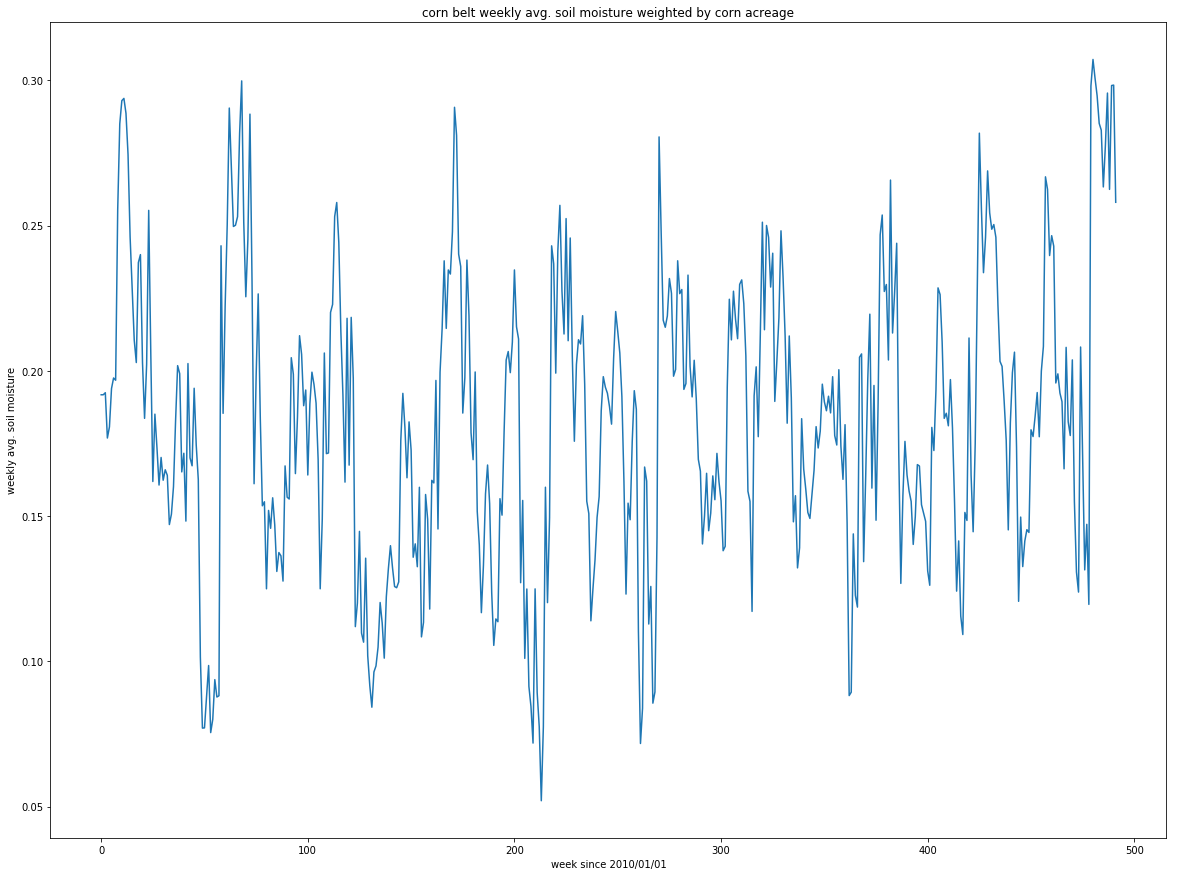

In [24]:
# corn belt weekly SMOS plot
fig, ax_corn = plt.subplots(1, 1, figsize=(20, 15))
corn_belt_weekly_corn_avg = np.average(np.array(corn_belt_weekly), axis=0, weights=county_acreage_3yr_avg_corn.values())

ax_corn.plot(corn_belt_weekly_corn_avg)
ax_corn.set_xlabel("week since 2010/01/01")
ax_corn.set_ylabel("weekly avg. soil moisture")
ax_corn.set_title("corn belt weekly avg. soil moisture weighted by corn acreage")

### compute + plot of TRMM weekly in corn belt

In [25]:
# sum over weekly for trmm
epoch_trmm = datetime.date(2000,3,6)
epoch_today = datetime.datetime.today().date()
num_weeks = (epoch_today - epoch_trmm).days//7
corn_belt_weekly_trmm = []
corn_belt_weekly_year_trmm = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        
        weekly_sum = np.zeros((num_weeks))
        weekly_count = np.zeros((num_weeks))
        weekly_progress = np.zeros((num_weeks))

        for datapoint in county_trmm_data[county_id]:
            datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
            week_idx = (datapointdate - epoch_trmm).days // 7
            if week_idx >= len(weekly_sum) or week_idx<0:
                continue
            if not datapoint["value"]:
                continue
            weekly_sum[week_idx] += datapoint["value"]
            weekly_count[week_idx] += 1
    
        corn_belt_weekly_trmm.append(weekly_sum)
        corn_belt_weekly_year_trmm.append(get_yearly(weekly_sum, 2001, 19, epoch_trmm))

Text(0.5,1,'corn belt weekly avg. soil moisture weighted by corn acreage')

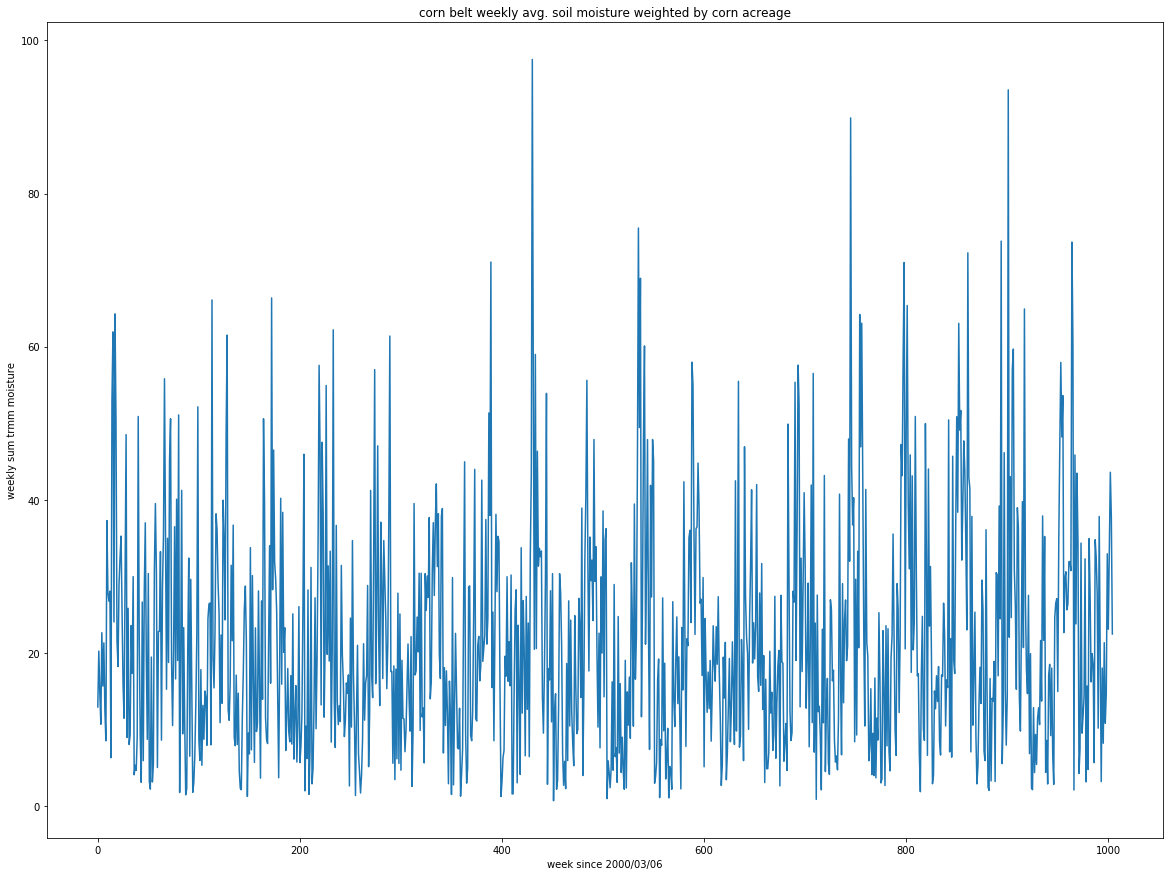

In [26]:
# corn belt weekly trmm visualization
fig, ax_corn = plt.subplots(1, 1, figsize=(20, 15))
corn_belt_weekly_trmm_corn_avg = np.average(np.array(corn_belt_weekly_trmm), axis=0, weights=county_acreage_3yr_avg_corn.values())

ax_corn.plot(corn_belt_weekly_trmm_corn_avg)
ax_corn.set_xlabel("week since 2000/03/06")
ax_corn.set_ylabel("weekly sum trmm moisture")
ax_corn.set_title("corn belt weekly avg. soil moisture weighted by corn acreage")

### compute + plot weekly progress

In [27]:
# places progress in an np-array and fills in missing 0s and 100s at either tail 
corn_belt_progress_weekly = []

for state_id in state_ids.values():
    dataseries = state_progress_data[state_id]

    weekly_progress_sum = np.zeros((num_weeks))
    weekly_progress_count = np.zeros((num_weeks))
    
    for datapoint in dataseries:
        datapointdate = datetime.datetime.strptime(datapoint["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ').date()
        week_idx = (datapointdate - epoch_smos).days // 7
        if week_idx < 0:
            continue
        weekly_progress_sum[week_idx] = datapoint["value"]
        weekly_progress_count[week_idx] += 1
    
    weekly_progress_avg = weekly_progress_sum
    corn_belt_progress_weekly.append(get_yearly(weekly_progress_avg, 2010, 10, epoch_smos))
    
corn_belt_progress_weekly = np.array(corn_belt_progress_weekly)
end_weeks = np.argmax(np.flip(np.array(corn_belt_progress_weekly)>0.0, axis=2), axis=2)
for state_idx in range(corn_belt_progress_weekly.shape[0]):
    # (current year let's leave it at NAN)
    for year_idx in range(corn_belt_progress_weekly.shape[1]):
        end_idx = end_weeks[state_idx, year_idx]
        # we can't make any assumptions here on the last year...
        if year_idx == corn_belt_progress_weekly.shape[1] - 1:
            corn_belt_progress_weekly[state_idx, year_idx, -end_idx:] = np.nan
        else:
            corn_belt_progress_weekly[state_idx, year_idx, -end_idx:] = 100

Text(0.5,1,'corn progress average in corn belt over states and years')

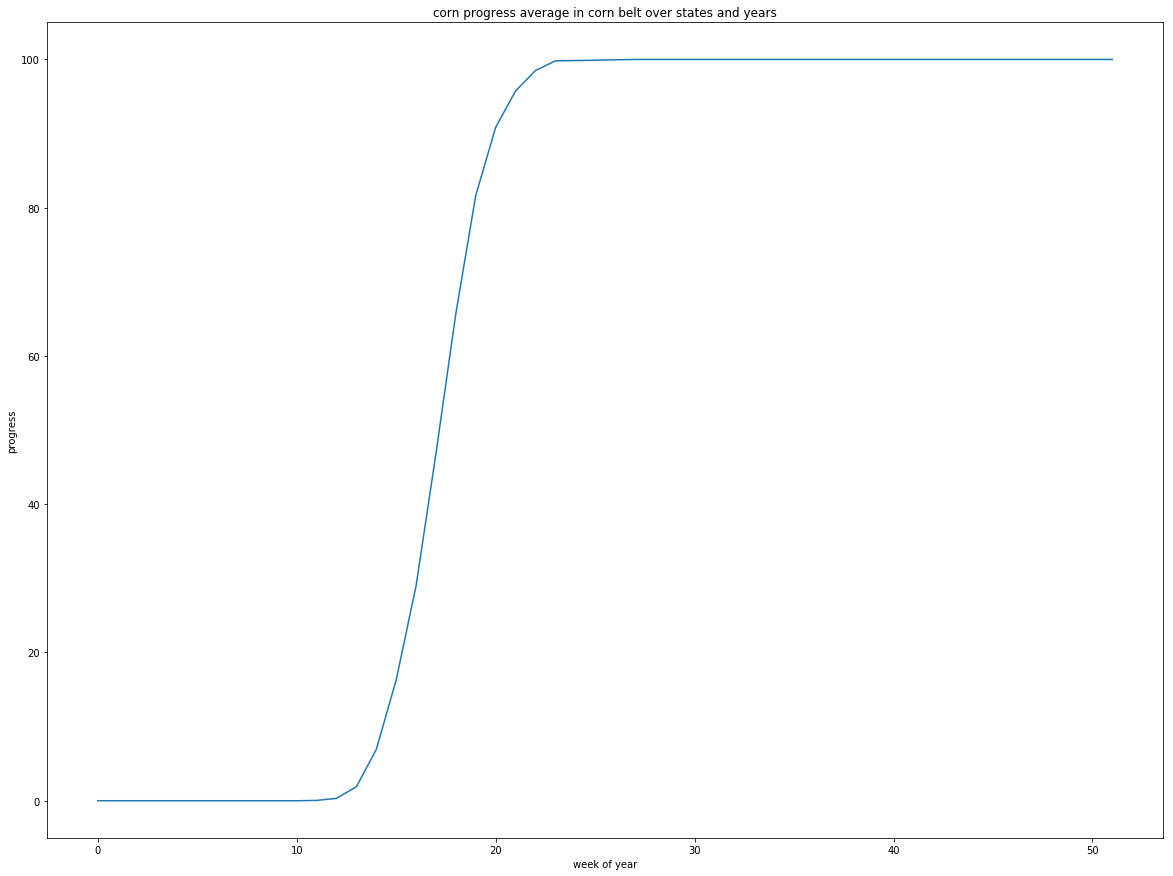

In [28]:
fig, ax_prog = plt.subplots(1, 1, figsize=(20, 15))
ax_prog.plot(np.mean(corn_belt_progress_weekly[:, :-1, :], axis=(0,1)))
ax_prog.set_xlabel("week of year")
ax_prog.set_ylabel("progress")
ax_prog.set_title("corn progress average in corn belt over states and years")

# Predict prevented/(prevented+failed+planted)

### simple linear model

In [30]:
# we alway use last weeks data for these sources, unless
# we specify an integer weekly lag in excess of that
lag_trmm = 0
lag_smos = 0
lag_prog = lag_progress = 0

simple linear model taking inputs from 2019-04-08 to 2019-04-15:
('county-level score:', 0.0637926799343157)


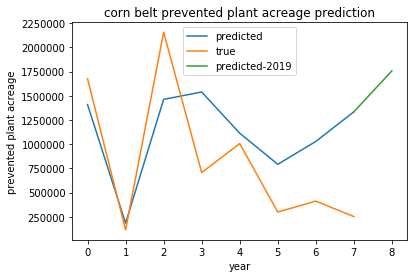

simple linear model taking inputs from 2019-04-08 to 2019-04-22:
('county-level score:', 0.0877153592887383)


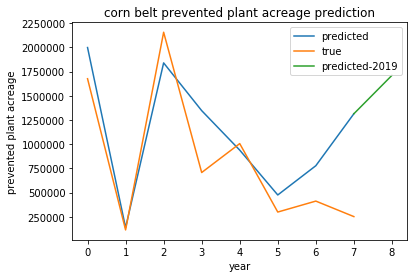

simple linear model taking inputs from 2019-04-08 to 2019-04-29:
('county-level score:', 0.09816967457182713)


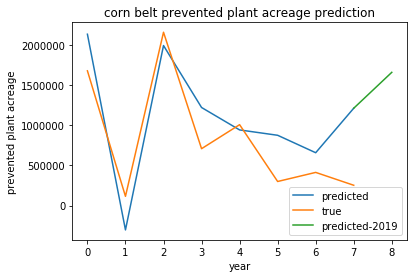

simple linear model taking inputs from 2019-04-08 to 2019-05-06:
('county-level score:', 0.11364433979981436)


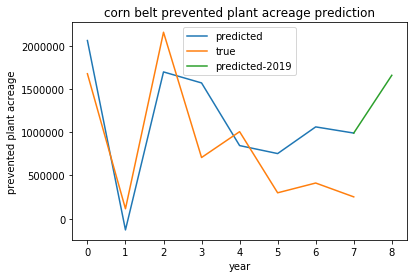

simple linear model taking inputs from 2019-04-08 to 2019-05-13:
('county-level score:', 0.14678682232678653)


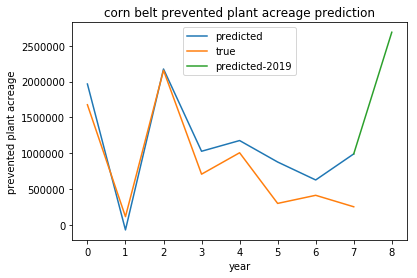

simple linear model taking inputs from 2019-04-08 to 2019-05-20:
('county-level score:', 0.15326117949010476)


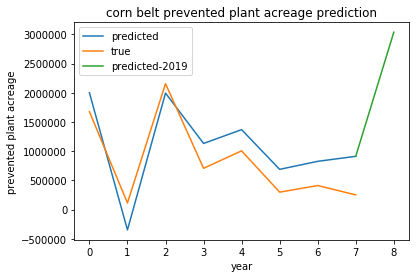

simple linear model taking inputs from 2019-04-08 to 2019-05-27:
('county-level score:', 0.1733480822186132)


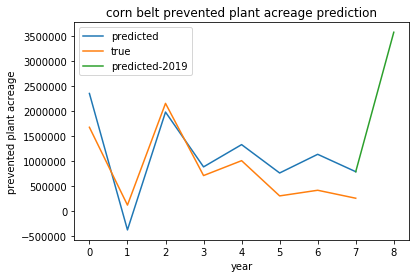

simple linear model taking inputs from 2019-04-08 to 2019-06-03:
('county-level score:', 0.19448209654578386)


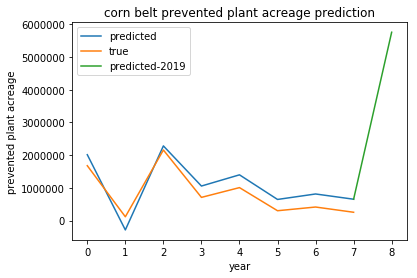

simple linear model taking inputs from 2019-04-08 to 2019-06-10:
('county-level score:', 0.22334028996227284)


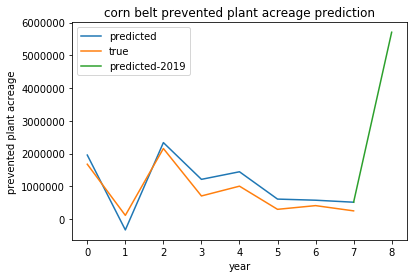

simple linear model taking inputs from 2019-04-08 to 2019-06-17:
('county-level score:', 0.23088033363018934)


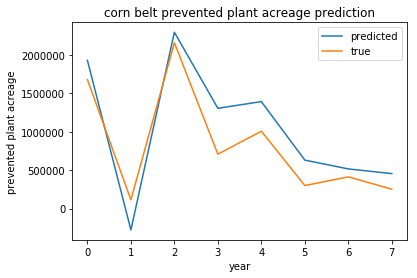

simple linear model taking inputs from 2019-04-08 to 2019-06-24:
('county-level score:', 0.25842242384907144)


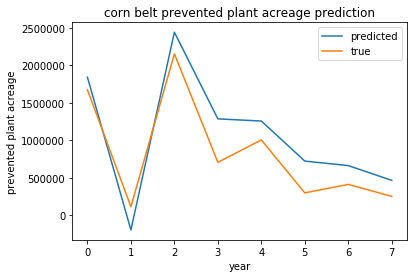

simple linear model taking inputs from 2019-04-08 to 2019-07-01:
('county-level score:', 0.258748814855289)


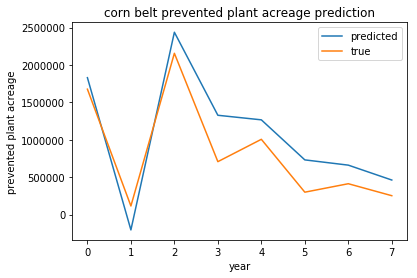

simple linear model taking inputs from 2019-04-08 to 2019-07-08:
('county-level score:', 0.25444738124231125)


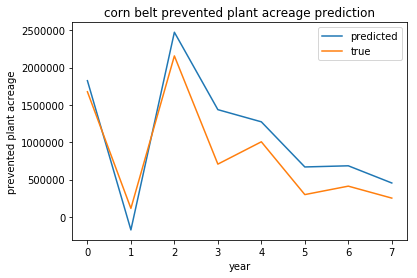

[1757416.7425316938, 1710554.9724689843, 1657310.1939348793, 1658110.7475354858, 2688030.7691704365, 3035660.6725251093, 3583419.925238359, 5756622.287165744, 5704723.298389595]


In [31]:
import sklearn.linear_model
from sklearn.model_selection import train_test_split



# the predictor
yearly_data_ratio = get_yearly_data_ratio('fsa_area_prevented_non_irrigated_corn')

# the feature idx we will use to get back to real-world numbers instead of a ratio
numerator_idx = features_list.index('fsa_area_prevented_non_irrigated_corn') 

y = np.reshape(yearly_data_ratio, -1)

# X_yearly has shape (county_idx, year, feature_idx) and is composed of features:
# deviation SMOS up to that week
# deviation TRMM up to that week
# crop progress up to that week

# week 14 is first week of april this year
# week 26 is last week of june this year
start_week = 14
start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

curr_year_prediction_list = []

for week_offset in range(1,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("simple linear model taking inputs from {} to {}:".format(start_date, end_date))
    X_yearly = np.zeros((num_counties, 9,week_offset*3 - lag_progress - lag_smos - lag_trmm))
    X_yearly[:,:,:] = np.nan # catch bugs
    
    county_idx = 0
    for idx, state_id in enumerate(state_ids.values()):
        X_yearly[county_idx:county_idx+len(county_ids[state_id]),:,0:week_offset - lag_progress] = corn_belt_progress_weekly[idx,-9:,start_week:week_idx - lag_progress]
        county_idx += len(county_ids[state_id])

    X_yearly[:,:,week_offset - lag_progress:week_offset*2 - lag_progress - lag_trmm] = np.array(corn_belt_weekly_year_trmm)[:,-9:,start_week:week_idx - lag_trmm]
    X_yearly[:,:,week_offset*2 - lag_progress - lag_trmm:week_offset*3 - lag_progress - lag_trmm - lag_smos] = np.array(corn_belt_weekly_year)[:,-9:,start_week:week_idx - lag_smos]

    # Uncomment to weight by corn acreage ratio in that county
    # X_yearly[:,:,week_offset*2 - lag_progress - lag_trmm:week_offset*3 - lag_progress - lag_trmm - lag_smos] *= weight_corn[:, np.newaxis, np.newaxis]
    # X_yearly[:,:,week_offset - lag_progress:week_offset*2 - lag_progress - lag_trmm] *= weight_corn[:, np.newaxis, np.newaxis]
    
    # X_yearly conssists of:
    # 0:week_offset columns for smos
    # week_offset:week_offset*2 columns for trmm
    # week_offset*2: weekoffset*3 columns for crop progress
    
    X_truncated = X_yearly[:, :-1, :]
    X = np.reshape(X_truncated, (-1, X_truncated.shape[2]))
    
    # for polynomial features do:
    # X = np.concatenate((X, X**2), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    reg_linear = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
    print("county-level score:", reg_linear.score(X_test,y_test))
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = []
    
    for year in range(8, 0, -1):
        yearly_prevented_predictions.append(np.sum(reg_linear.predict(X_truncated[:, -year, :])*denominator_values_prediction[:, -year]))
    
    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    if not np.any(np.isnan(X_yearly[:, -1, :])):
        curr_year_prediction = reg_linear.predict(X_yearly[:, -1, :]) * np.mean(denominator_values_prediction[:, -3:], axis=1)
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.title("corn belt prevented plant acreage prediction")
    plt.xlabel("year")
    plt.ylabel("prevented plant acreage")
    plt.legend()
    plt.show()

print(curr_year_prediction_list)

### xgboost model

In [32]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
"""Creating a dataframe with desired features and target: 
smos: smos_week_i represents smos (deviation) of week i
trmm: trmm_week_i represents trmm (deviation) of week i
progress: prog_week_i represents planting progress (state level broadcasted to county level) of week i  
ratio: prevented acreage as a fraction of prevented+failed+planted
absolute: prevented acreage
"""
smos_cols = ['smos_week_'+str(i) for i in range(start_week+1, start_week+14-lag_smos)]
trmm_cols = ['trmm_week_'+str(i) for i in range(start_week+1, start_week+14-lag_trmm)]
prog_cols = ['prog_week_'+str(i) for i in range(start_week+1, start_week+14-lag_prog)]
features = prog_cols + trmm_cols + smos_cols
df_latestyear = pd.DataFrame(X_yearly[:,-1,:], columns=features)
df = pd.DataFrame(X, columns=features)
df.loc[:, 'ratio'] = y
y_absolute = np.reshape(yearly_data[:,:,numerator_idx], (-1))
df.loc[:, 'planted'] = np.reshape(denominator_values_prediction, (-1))
df.loc[:, 'absolute'] = y_absolute

In [33]:
# Analyst recommended patch to move ILLINOIS over IOWA in latestyear
iowa_state = client.lookup('regions', 13066)
illi_state = client.lookup("regions", 13064)
iowa_latlon = np.array((iowa_state.get("latitude"), iowa_state.get("longitude")))
illi_latlon = np.array((illi_state.get("latitude"), illi_state.get("longitude")))

delta_latlon = (iowa_latlon - illi_latlon)

In [34]:
"""Adding latitude and longitude as features
lat: latitude of the county
lon: longitude of the county
"""

import itertools
county_list = []
lat_list = []
lon_list = []
lat_list_patched = []
lon_list_patched = []
for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        county_list.append(county_id)
        county = client.lookup('regions', county_id)  
        lat_list.append(county.get('latitude'))
        lon_list.append(county.get('longitude'))
        
        lat_list_patched.append(county.get('latitude'))
        lon_list_patched.append(county.get('longitude'))
        
        # place illinois on top of iowa
        if state_id == 13064:
            lat_list_patched[-1] += delta_latlon[0]
            lon_list_patched[-1] += delta_latlon[1]

df.loc[:, 'region_id'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in county_list)))
df.loc[:, 'lat'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in lat_list)))
df.loc[:, 'lon'] = list(itertools.chain.from_iterable((itertools.repeat(i, 8) for i in lon_list)))
df_latestyear.loc[:, 'lat'] = lat_list_patched
df_latestyear.loc[:, 'lon'] = lon_list_patched

In [35]:
df.loc[:, 'year'] = range(2011, 2019)*918

model taking inputs from 2019-04-08 to 2019-04-15:
county-level score for ratio r2: -0.00363868029428, mse: 0.00261347388154
county-level score for absolute r2: 0.00065105278283, mse: 15863755.4393
belt-level mean absolute deviation is: 673099.688064


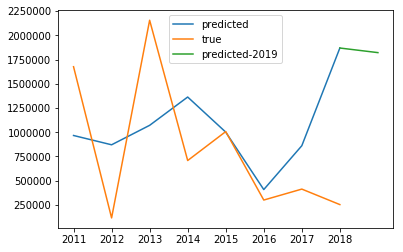

model taking inputs from 2019-04-08 to 2019-04-22:
county-level score for ratio r2: -0.0192414570831, mse: 0.00265410349299
county-level score for absolute r2: -0.0799028619281, mse: 17142475.5563
belt-level mean absolute deviation is: 503710.791685


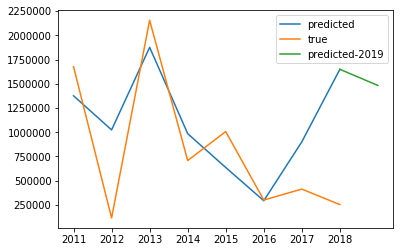

model taking inputs from 2019-04-08 to 2019-04-29:
county-level score for ratio r2: 0.0125476841185, mse: 0.00257132460863
county-level score for absolute r2: -0.164942128954, mse: 18492396.5609
belt-level mean absolute deviation is: 535925.451817


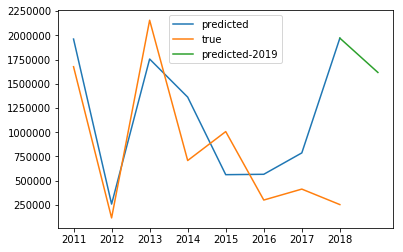

model taking inputs from 2019-04-08 to 2019-05-06:
county-level score for ratio r2: -0.0272407046879, mse: 0.00267493352385
county-level score for absolute r2: -0.151902415681, mse: 18285402.9748
belt-level mean absolute deviation is: 604398.183232


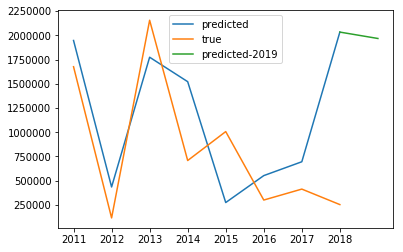

model taking inputs from 2019-04-08 to 2019-05-13:
county-level score for ratio r2: 0.101706369807, mse: 0.00233915550143
county-level score for absolute r2: 0.0168463382723, mse: 15606670.0149
belt-level mean absolute deviation is: 627311.360642


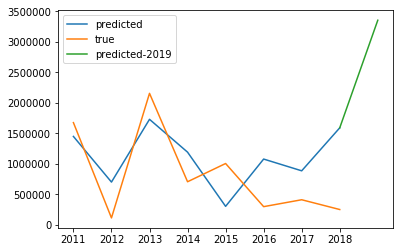

model taking inputs from 2019-04-08 to 2019-05-20:
county-level score for ratio r2: 0.11027761301, mse: 0.00231683599474
county-level score for absolute r2: 0.0920904633367, mse: 14412237.9783
belt-level mean absolute deviation is: 585036.564481


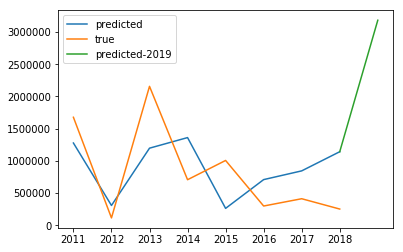

model taking inputs from 2019-04-08 to 2019-05-27:
county-level score for ratio r2: 0.177568429088, mse: 0.00214161079294
county-level score for absolute r2: 0.233443762575, mse: 12168382.9406
belt-level mean absolute deviation is: 532029.600872


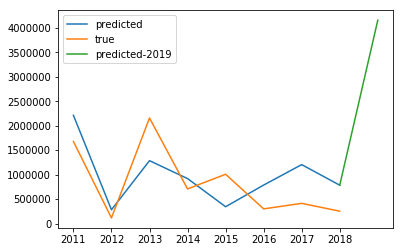

model taking inputs from 2019-04-08 to 2019-06-03:
county-level score for ratio r2: 0.183538103573, mse: 0.00212606576797
county-level score for absolute r2: 0.312411004009, mse: 10914849.8185
belt-level mean absolute deviation is: 364532.610706


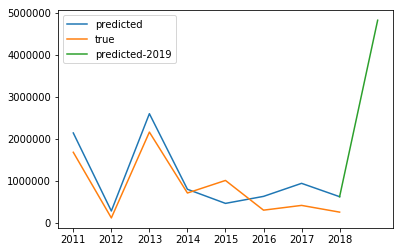

model taking inputs from 2019-04-08 to 2019-06-10:
county-level score for ratio r2: 0.214041044158, mse: 0.00204663614843
county-level score for absolute r2: 0.314441208127, mse: 10882622.175
belt-level mean absolute deviation is: 418997.319194


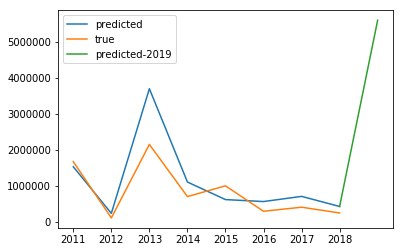

model taking inputs from 2019-04-08 to 2019-06-17:
county-level score for ratio r2: 0.217453219899, mse: 0.00203775084702
county-level score for absolute r2: 0.320254683779, mse: 10790338.5375
belt-level mean absolute deviation is: 427229.844098


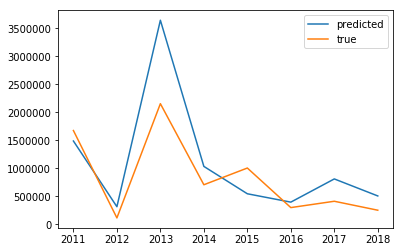

model taking inputs from 2019-04-08 to 2019-06-24:
county-level score for ratio r2: 0.247418107952, mse: 0.00195972231561
county-level score for absolute r2: 0.309557181951, mse: 10960151.6476
belt-level mean absolute deviation is: 301031.897302


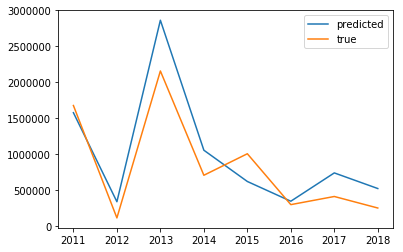

model taking inputs from 2019-04-08 to 2019-07-01:
county-level score for ratio r2: 0.255507602972, mse: 0.00193865728059
county-level score for absolute r2: 0.37273695357, mse: 9957230.24716
belt-level mean absolute deviation is: 324245.091535


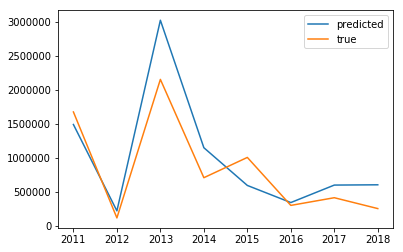

model taking inputs from 2019-04-08 to 2019-07-08:
county-level score for ratio r2: 0.263179721323, mse: 0.0019186790939
county-level score for absolute r2: 0.381776224312, mse: 9813740.04706
belt-level mean absolute deviation is: 275888.45432


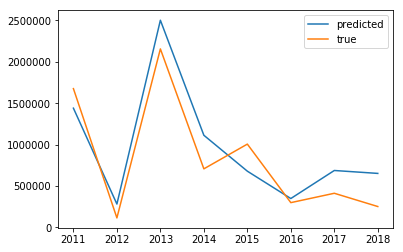

In [43]:
"""
Out of sample testing (leave one year out)
"""
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

start_date = datetime.datetime.strptime('2019-{}'.format(start_week*7), '%Y-%j').date()

metrics = ['belt_mae', 'county_ratio_r2', 'county_ratio_mse', 'county_absolute_r2', 'county_absolute_mse']
df_metrics = pd.DataFrame(columns=metrics)

curr_year_prediction_list = []

belt_mae_l = []
county_ratio_r2= []
county_ratio_mse = []
county_absolute_r2 = []
county_absolute_mse = []

for week_offset in range(1,14):
    
    week_idx = start_week + week_offset
    end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()
    
    print("model taking inputs from {} to {}:".format(start_date, end_date))

    features_week = prog_cols[:week_offset-lag_prog] + smos_cols[:week_offset-lag_smos] + trmm_cols[:week_offset-lag_trmm]
    features_week += ['lat', 'lon']
    denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
    yearly_prevented_predictions = []    
    df.loc[:, 'pred_ratio'] = 0
    df.loc[:, 'pred_absolute'] = 0

    for year in range(8):
        # training on rows whose year column != year
        # predicting and scoring on rows whose year column == year
        test_year = 2011 + year
        reg = XGBRegressor()
        
        # uncomment to only train on counties with any corn planted
        #df = df.loc[df.planted > 0.0]
        
        X_train = df.loc[df.year!=test_year, features_week]
        y_train = df.loc[df.year!=test_year, 'ratio']
        X_test = df.loc[df.year==test_year, features_week]
        y_test = df.loc[df.year==test_year, 'ratio']
        reg.fit(X_train,y_train)
        df.loc[df.year==test_year, 'pred_ratio'] = reg.predict(X_test)
        df.loc[df.year==test_year, 'pred_absolute'] = reg.predict(X_test)*denominator_values_prediction[:, -year]
        yearly_prevented_predictions.append(np.sum(reg.predict(X_test)*denominator_values_prediction[:, -year]))
    
    # plotting belt level aggregation
    ratio_r2 = r2_score(df['ratio'], df['pred_ratio'])
    county_ratio_r2.append(ratio_r2)
    ratio_mse = mean_squared_error(df['ratio'], df['pred_ratio'])
    county_ratio_mse.append(ratio_mse)
    print("county-level score for ratio r2: {}, mse: {}".format(ratio_r2, ratio_mse))
    absolute_r2 = r2_score(df['absolute'], df['pred_absolute'])
    county_absolute_r2.append(absolute_r2)
    absolute_mse = mean_squared_error(df['absolute'], df['pred_absolute'])
    county_absolute_mse.append(absolute_mse)
    print("county-level score for absolute r2: {}, mse: {}".format(absolute_r2, absolute_mse))
    belt_mae = mean_absolute_error(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), yearly_prevented_predictions)
    belt_mae_l.append(belt_mae)
    print("belt-level mean absolute deviation is: {}".format(belt_mae))
    df_metrics.loc[week_idx] = [belt_mae, ratio_r2, ratio_mse, absolute_r2, absolute_mse]

    plt.plot(yearly_prevented_predictions, label="predicted")
    plt.plot(np.sum(yearly_data[:,-8:,numerator_idx], axis=0), label="true")
    
    # make predictions for the first 9 weeks
    if not np.any(np.isnan(df_latestyear.loc[:, features_week])):
        reg = XGBRegressor()
        reg.fit(df[features_week], df['ratio'])
        curr_year_prediction_ratio = reg.predict(df_latestyear.loc[:, features_week]) 
        curr_year_prediction = curr_year_prediction_ratio * np.mean(denominator_values_prediction[:, -3:], axis=1) # county_acreage_3yr_avg_corn_list * 2.47105
        curr_year_sum = np.sum(curr_year_prediction)
        curr_year_prediction_list.append(curr_year_sum)
        plt.plot((7,8), (yearly_prevented_predictions[-1], curr_year_sum), label="predicted-2019")
    
    plt.xticks(range(8), range(2011, 2019))
    plt.legend()
    plt.show()

In [44]:
results_df = pd.DataFrame([["prediction_2019"] + curr_year_prediction_list,
                           ["belt_mae_l"] + belt_mae_l, 
                           ["county_ratio_r2"] + county_ratio_r2, 
                           ["county_ratio_mse"] + county_ratio_mse, 
                           ["county_absolute_r2"] + county_absolute_r2, 
                           ["county_absolute_mse"] + county_absolute_mse])

results_df.columns = ["metric"] + ["week {}".format(i) for i in range(13)]
results_df.set_index("metric")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(results_df)

,metric,week 0,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12
0,prediction_2019,1821614.477,1482640.207,1616819.219,1967645.427,3353837.684,3181590.075,4153870.929,4817156.552,5605184.245,nan,nan,nan,nan
1,belt_mae_l,673099.688,503710.792,535925.452,604398.183,627311.361,585036.564,532029.601,364532.611,418997.319,427229.844,301031.897,324245.092,275888.454
2,county_ratio_r2,-0.004,-0.019,0.013,-0.027,0.102,0.110,0.178,0.184,0.214,0.217,0.247,0.256,0.263
3,county_ratio_mse,0.003,0.003,0.003,0.003,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
4,county_absolute_r2,0.001,-0.080,-0.165,-0.152,0.017,0.092,0.233,0.312,0.314,0.320,0.310,0.373,0.382
5,county_absolute_mse,15863755.439,17142475.556,18492396.561,18285402.975,15606670.015,14412237.978,12168382.941,10914849.819,10882622.175,10790338.537,10960151.648,9957230.247,9813740.047


# CHOROPLETHS

In [38]:
# Choropleth
import geopandas
import pandas as pd
import os
from shapely.geometry import shape

###
### GeoDataFrame has no simple support for loading a dict-of-json in python. Used workaround from here:
### https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe
###

gdf = geopandas.GeoDataFrame()
county_areas = []

for state_id in state_ids.values():
    for county_id in county_ids[state_id]:
        geojson = client.get_geojson(county_id)
        geojson["geometries"] = shape(geojson["geometries"][0])
        new_gdf = geopandas.GeoDataFrame(geojson).set_geometry("geometries")
        new_gdf["district_id"] = county_id
        # TODO: currently we ignore any secondary polygons that are separate from the main 
        # county polygon. figure out how to add these to the same geodataframe
        new_gdf.crs = {'init' :'epsg:4326'}
        area_acres = new_gdf['geometries'].to_crs({'init': 'epsg:3395'})\
            .map(lambda p: (p.area / 10**4))[0]
        new_gdf["area"] = area_acres
        county_areas.append(area_acres)
        gdf = pd.concat([gdf, new_gdf.iloc[[0]]])
df_district = gdf

gdf = geopandas.GeoDataFrame()
for state_id in state_ids.values():
    geojson = client.get_geojson(state_id)
    geojson["geometries"] = shape(geojson["geometries"][0])    
    new_gdf = geopandas.GeoDataFrame(geojson).set_geometry("geometries")
    # TODO: currently we ignore any secondary polygons that are separate from the main 
    # county polygon. figure out how to add these to the same geodataframe
    new_gdf.crs = {'init' :'epsg:4326'}
    gdf = pd.concat([gdf, new_gdf])
df_state = gdf

In [39]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
musen_colors = [
    (89, 3, 4),
    (139, 13, 25),
    (186, 24, 44),
    (227, 51, 77),
    (237, 132, 147), 
    (249, 214, 218),
    (255, 255, 255), 
    (209, 224, 230), 
    (121, 163, 182),
    (34, 100, 135),
    (11, 73, 109),
    (8, 56, 92),
    (3, 41, 69)
]
musen_colors_blue = [
    (255, 255, 255),
    (175, 213, 227), 
    (97, 171, 199), 
    (47, 129, 163),
    (24, 85, 118), 
    (2, 41, 70)
]
musen_colors = np.array(musen_colors)/256.0
musen_colors_blue = np.array(musen_colors_blue)/256.0

musen_cmap = LinearSegmentedColormap.from_list('musen_red_blue', musen_colors, N=len(musen_colors)*10)

musen_cmap_blue = LinearSegmentedColormap.from_list('musen_blue', musen_colors_blue, N=len(musen_colors_blue)*10)

## Plot county-level prevented planting predictions

82994.84600786559


/home/ubuntu/.local/lib/python2.7/site-packages/geopandas/plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


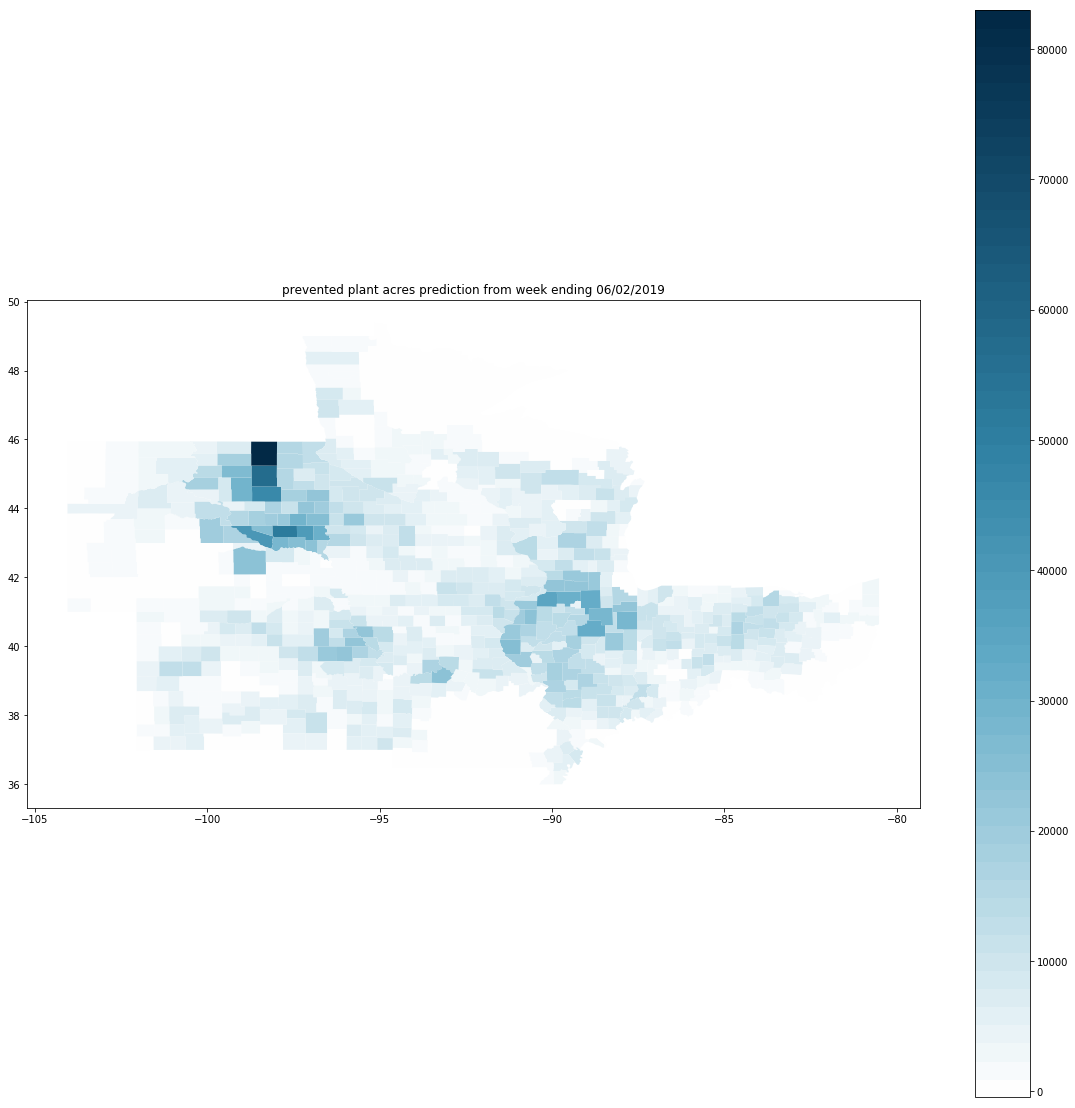

In [40]:
df_district["ratio"] = curr_year_prediction_ratio
df_district["prediction"] = curr_year_prediction
print(np.max(curr_year_prediction))
fix, ax = plt.subplots(1, 1, figsize=(20,20))
df_district.plot("prediction", legend=True, axes=ax, cmap=musen_cmap_blue)
ax.set_title("prevented plant acres prediction from week ending 06/02/2019")
df_district.to_file("prevented_prediction.shp")

## Plot county-level backtesting performance

In [41]:
week_offset = 8
week_idx = start_week + week_offset
end_date = datetime.datetime.strptime('2019-{}'.format(week_idx*7), '%Y-%j').date()

print("model taking inputs from {} to {}:".format(start_date, end_date))

features_week = prog_cols[:week_offset-lag_prog] + smos_cols[:week_offset-lag_smos] + trmm_cols[:week_offset-lag_trmm]
features_week += ['lat', 'lon']

denominator_values_prediction = np.sum(yearly_data[:,:,denominator_idxs], axis=2)
yearly_prevented_predictions = []    
df.loc[:, 'pred_ratio'] = 0
df.loc[:, 'pred_absolute'] = 0
for year in range(8):
    # training on rows whose year column != year
    # predicting and scoring on rows whose year column == year
    test_year = 2011 + year
    reg = XGBRegressor()
    X_train = df.loc[df.year!=test_year, features_week]
    y_train = df.loc[df.year!=test_year, 'ratio']
    X_test = df.loc[df.year==test_year, features_week]
    y_test = df.loc[df.year==test_year, 'ratio']
    reg.fit(X_train,y_train)
    df.loc[df.year==test_year, 'pred_ratio'] = reg.predict(X_test)
    df.loc[df.year==test_year, 'pred_absolute'] = reg.predict(X_test)*denominator_values_prediction[:, -year]
    print("county-level score of year {}:".format(test_year), reg.score(X_test,y_test))
    yearly_prevented_predictions.append(np.sum(reg.predict(X_test)*denominator_values_prediction[:, -year]))
df.loc[:, 'deviation'] = abs(df['pred_absolute'] - df['absolute'])
df_deviation = df.groupby('region_id').mean()['deviation'].reset_index()
df_deviation = df_district.merge(df_deviation, left_on='district_id', right_on='region_id')

model taking inputs from 2019-04-08 to 2019-06-03:
('county-level score of year 2011:', 0.23370407395639314)
('county-level score of year 2012:', -2.1978951436360408)
('county-level score of year 2013:', 0.05144758263311422)
('county-level score of year 2014:', 0.32173514500793154)
('county-level score of year 2015:', 0.05265380481055393)
('county-level score of year 2016:', -0.1852586139299279)
('county-level score of year 2017:', 0.030443319091972953)
('county-level score of year 2018:', 0.23946514663941632)


Text(0.5,1,'mean absolute deviation from backtesting week ending 06/02/2019')

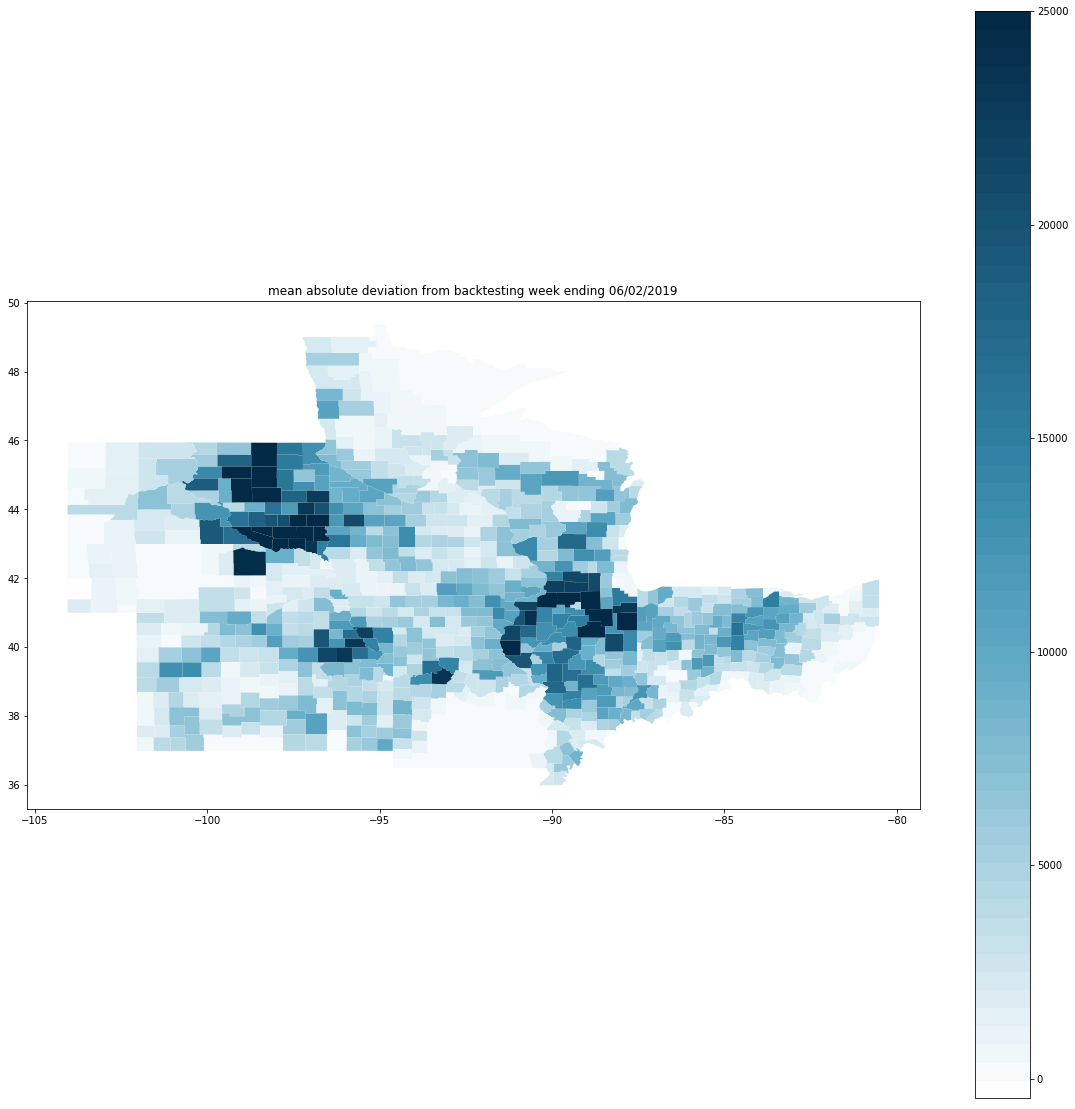

In [45]:
fix, ax = plt.subplots(1, 1, figsize=(20,20))
df_deviation.plot("prediction", legend=True, axes=ax, vmax=25000,cmap=musen_cmap_blue)
ax.set_title("mean absolute deviation from backtesting week ending 06/02/2019")